In [ ]:
from PolyCAMB import *

np.float64(2.62243154241303e-09)

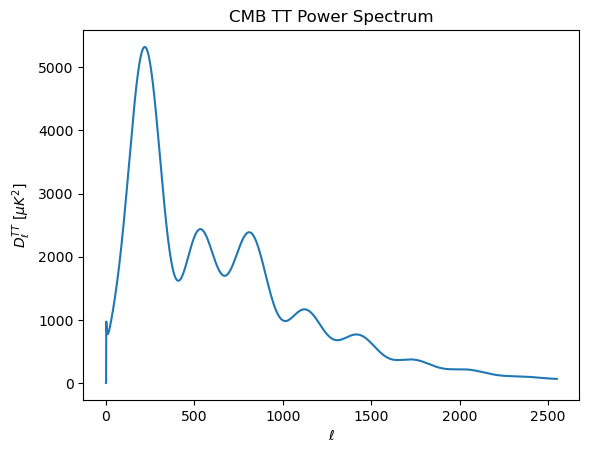

In [1]:
import camb
from camb import model, initialpower
import numpy as np

ombh2 = 0.03959524 * 0.21776921**2
omch2 = 0.18287274 * 0.21776921**2
H0 = 100 * 0.21776921
tau = 0.49724617
ns = 1.08095159
As =1e-10 * np.exp(3.26668705)

ombh2 = 0.022
omch2 = 0.122
tau = 0.06
As = 2e-9
ns = 0.965
H0 = 67.5

# Set parameters
pars = camb.CAMBparams()
pars.set_cosmology(H0=H0, ombh2=ombh2, omch2=omch2, tau=tau)
pars.InitPower.set_params(As=As, ns=ns)
pars.set_for_lmax(2500, lens_potential_accuracy=1)

# Run the calculation
results = camb.get_results(pars)
powers = results.get_cmb_power_spectra(pars, CMB_unit='muK')

# Extract TT spectrum
import matplotlib.pyplot as plt
cls = powers['total']
ell = range(cls.shape[0])

plt.plot(ell, cls[:,0])  # TT
plt.xlabel(r'$\ell$')
#plt.yscale('log')
plt.ylabel(r'$D_\ell^{TT}$ [$\mu K^2$]')
plt.title('CMB TT Power Spectrum')
plt.show()


In [21]:
ells = np.arange(cls.shape[0])

In [23]:
import numpy as np
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d

def find_cls_peaks(ell, Cl, smooth_sigma=1.5, height=None, distance=20):
    """
    Find peak positions and heights in a TT CMB power spectrum.

    Parameters:
    - ell: array of multipoles (ℓ)
    - Cl: array of C_ell values (same length as ell)
    - smooth_sigma: optional Gaussian smoothing width (in pixels)
    - height: minimum height of peak (can be scalar or tuple for range)
    - distance: minimum distance between peaks (in ℓ pixels)

    Returns:
    - ell_peaks: ℓ values at peaks
    - Cl_peaks: corresponding C_ell values at peaks
    """

    # Step 1: Optional smoothing
    Cl_smooth = gaussian_filter1d(Cl, sigma=smooth_sigma)

    # Step 2: Find peaks
    peak_indices, _ = find_peaks(Cl_smooth, height=height, distance=distance)

    ell_peaks = ell[peak_indices]
    Cl_peaks = Cl_smooth[peak_indices]

    return ell_peaks, Cl_peaks

ell_peaks, Cl_peaks = find_cls_peaks(ells, cls[:,0])

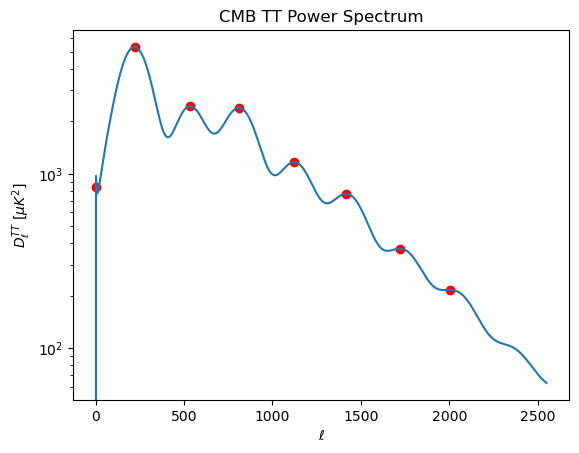

In [25]:
plt.plot(ell, cls[:,0])  # TT
plt.scatter(ell_peaks, Cl_peaks, color='red', label='Peaks')
plt.xlabel(r'$\ell$')
plt.yscale('log')
plt.ylabel(r'$D_\ell^{TT}$ [$\mu K^2$]')
plt.title('CMB TT Power Spectrum')
plt.show()

In [8]:
    # Step 1: Optional smoothing
Cl_smooth = gaussian_filter1d(cls[:,0], sigma=1.5)

    # Step 2: Find peaks
peak_indices, _ = find_peaks(Cl_smooth, height=None, distance=20)

In [17]:
ell

range(0, 2551)

In [15]:
cls[peak_indices, 0]

array([ 832.59973231, 5323.40205278, 2437.12918101, 2387.83493829,
       1166.36884055,  768.18651877,  372.58453366,  216.35821378])

In [ ]:
inds = [ 5  220  534  810 1122 1416 1720 2002]
np.arange(2, 2502)[]

In [ ]:
import numpy as np
import camb
from camb import model, initialpower
import pandas as pd

from tqdm import tqdm
from tqdm_joblib import tqdm_joblib
from joblib import Parallel, delayed


# -----------------------------
# Define parameter sampling space
# -----------------------------
def sample_parameters(N):
    # Parameter ranges (ΛCDM typical priors)
    return pd.DataFrame({
        'ombh2': np.random.uniform(0.015, 0.033, N),     # Ω_b h²
        'omch2': np.random.uniform(0.05, 0.23, N),        # Ω_c h²
        'H0':    np.random.uniform(45, 85, N),            # Hubble parameter
        'ns':    np.random.uniform(0.8, 1.0, N),         # Spectral index
        'As':    np.random.uniform(1.8e-9, 2.4e-9, N),     # Scalar amplitude
        'tau':   np.random.uniform(0.04, 0.08, N)          # Optical depth
    })

# -----------------------------
# Run CAMB for a given parameter vector
# -----------------------------
def get_cls(theta, lmax=2500):
    pars = camb.CAMBparams()

    # Set cosmological parameters
    pars.set_cosmology(H0=theta['H0'], ombh2=theta['ombh2'], omch2=theta['omch2'], tau=theta['tau'])

    # Initial power spectrum parameters
    pars.InitPower.set_params(As=theta['As'], ns=theta['ns'])

    # Compute lensed CMB power spectra up to lmax
    pars.set_for_lmax(lmax, lens_potential_accuracy=0)
    results = camb.get_results(pars)
    powers = results.get_cmb_power_spectra(pars, CMB_unit='muK')

    # Extract total TT spectrum (including lensing)
    totCL = powers['total']
    ell = np.arange(totCL.shape[0])

    return ell, totCL[:, 0]  # Return (ℓ, C_ℓ^TT)

# -----------------------------
# Main loop: generate dataset
# -----------------------------
def generate_dataset(N=500, lmax=2000, ell_sampling='log'):
    """
    Generate a dataset of CMB power spectra using CAMB.
    Parameters:
    - N: number of simulations
    - lmax: maximum multipole to compute
    - ell_sampling: 'log' for log-sampling ℓ, 'linear' for linear sampling
    Returns:
    - X: parameters (N x 6)
    - Y: CMB power spectra (N x len(ell_sampled))
    - param_names: list of parameter names
    - ell_sampled: sampled ℓ values
    """
    params = sample_parameters(N)
    ell_range = np.arange(2, lmax + 1)

    # Optional: log-sample ℓ to reduce data dimensionality
    if ell_sampling == 'log':
        ell_sampled = np.unique(np.round(np.exp(np.linspace(np.log(2), np.log(lmax), 200))).astype(int))
        ell_sampled = ell_sampled[ell_sampled <= lmax]
    else:
        ell_sampled = np.arange(2, lmax + 1)

    Cls_all = []

    for i in tqdm(range(N), desc="Running CAMB"):
        theta = params.iloc[i]
        ell, Cl_tt = get_cls(theta, lmax=lmax)
        if ell_sampling is not None:
            # Interpolate to sampled ℓs
            Cl_sampled = np.interp(ell_sampled, ell, Cl_tt)
            Cls_all.append(Cl_sampled)
        else:
            ell_sampled = ell
            Cls_all.append(Cl_tt)

    # Final array: (N samples) x (len(ell_sampled) features)
    X = params.to_numpy()
    Y = np.array(Cls_all)

    return X, Y, params.columns.tolist(), ell_sampled

# Wrapper function for one simulation

def run_camb_and_interp(theta_row, lmax, ell_sampled):
    ell, Cl_tt = get_cls(theta_row, lmax=lmax)
    return np.interp(ell_sampled, ell, Cl_tt)

def run_camb(theta_row, lmax):
    _, Cl_tt = get_cls(theta_row, lmax=lmax)
    return Cl_tt

def generate_dataset_para(N=500, lmax=2000, ell_sampling='log'):
    params = sample_parameters(N)
    ell_range = np.arange(2, lmax + 1)

    # Optional: log-sample ℓ to reduce data dimensionality
    if ell_sampling == 'log':
        ell_sampled = np.unique(np.round(np.exp(np.linspace(np.log(2), np.log(lmax), 200))).astype(int))
        ell_sampled = ell_sampled[ell_sampled <= lmax]
    else:
        ell_sampled = np.arange(2, lmax + 1)

    Cls_all = []

    # Convert dataframe rows to list of dicts for easy parallel processing
    theta_list = [params.iloc[i] for i in range(len(params))]


    if ell_sampling is None:
        with tqdm_joblib(tqdm(desc="Running CAMB", total=len(theta_list))) as _:
            Cls_all = Parallel(n_jobs=-1, backend="loky")(
                delayed(run_camb)(theta, lmax) for theta in theta_list
            )
    else:
        with tqdm_joblib(tqdm(desc="Running CAMB", total=len(theta_list))) as _:
            Cls_all = Parallel(n_jobs=-1, backend="loky")(
                delayed(run_camb_and_interp)(theta, lmax, ell_sampled) for theta in theta_list
            )

    # Final array: (N samples) x (len(ell_sampled) features)
    X = params.to_numpy()
    Y = np.array(Cls_all)

    return X, Y, params.columns.tolist(), ell_sampled



import numpy as np
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d

def find_cls_peaks(ell, Cl, smooth_sigma=1.5, height=None, distance=20):
    """
    Find peak positions and heights in a TT CMB power spectrum.

    Parameters:
    - ell: array of multipoles (ℓ)
    - Cl: array of C_ell values (same length as ell)
    - smooth_sigma: optional Gaussian smoothing width (in pixels)
    - height: minimum height of peak (can be scalar or tuple for range)
    - distance: minimum distance between peaks (in ℓ pixels)

    Returns:
    - ell_peaks: ℓ values at peaks
    - Cl_peaks: corresponding C_ell values at peaks
    """

    # Step 1: Optional smoothing
    Cl_smooth = gaussian_filter1d(Cl, sigma=smooth_sigma)

    # Step 2: Find peaks
    peak_indices, _ = find_peaks(Cl_smooth, height=height, distance=distance)

    ell_peaks = ell[peak_indices]
    Cl_peaks = Cl_smooth[peak_indices]

    return ell_peaks, Cl_peaks


/opt/homebrew/Caskroom/miniconda/base/envs/astro_env/lib/python3.12/site-packages/tqdm_joblib/__init__.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
X, Y, param_names, ells = generate_dataset_para(N=200000, lmax=2000, ell_sampling=None)

# Save the parameter array
np.save('params.npy', X)

# Save the output array
np.save('output.npy', Y)

Running CAMB:   0%|          | 0/200000 [00:00<?, ?it/s]

  0%|          | 0/200000 [00:00<?, ?it/s]

/opt/homebrew/Caskroom/miniconda/base/envs/astro_env/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


KeyboardInterrupt: 

In [9]:
testXb, testYb, aux1b, aux2b = generate_dataset(N=500, lmax=2000, ell_sampling=None)
# 

Running CAMB:   0%|          | 0/500 [00:00<?, ?it/s]

Running CAMB: 100%|██████████| 500/500 [01:09<00:00,  7.19it/s]


In [13]:


# Example: 2D input, 3-dimensional output (e.g. CMB bandpowers)
np.random.seed(0)
N, n, m = 500, 2, 3
X = np.random.uniform(-1, 1, size=(N, n))
Y = np.stack([
    np.sin(np.pi * X[:, 0]),
    np.cos(np.pi * X[:, 1]),
    X[:, 0] * X[:, 1]
], axis=1)  # shape: N x m

degree = 3
M, nu, multi_indices = compute_moments_vector_output(X, Y, degree)
coeffs = solve_emulator_coefficients(M, nu)

# Symbolic representation
exprs, vars_sym = symbolic_polynomial_expressions(coeffs, multi_indices)
for j, expr in enumerate(exprs):
    print(f"\nOutput #{j+1}:")
    print("f(x) =", expr)



Output #1:
f(x) = -2.8955201841406*x1**3 - 0.0073464332045055*x1**2*x2 + 0.00688086080646594*x1**2 - 0.0110382522924001*x1*x2**2 + 0.001343976319932*x1*x2 + 2.70358544467259*x1 + 0.0155800219785798*x2**3 + 0.00160613063548975*x2**2 - 0.00967564944151897*x2 - 0.00151238750640837

Output #2:
f(x) = 0.00965535451994292*x1**3 - 0.0394080958653349*x1**2*x2 - 0.0262117144199794*x1**2 + 0.0600908828112534*x1*x2**2 - 0.0431156919133417*x1*x2 - 0.00977131375544649*x1 - 0.00259441237929385*x2**3 - 2.31111423832847*x2**2 + 0.0253170271411479*x2 + 0.781413957348578

Output #3:
f(x) = -4.52861644418751e-18*x1**3 - 1.30947519525879e-17*x1**2*x2 - 6.05766170691534e-19*x1**2 + 7.53952343410115e-18*x1*x2**2 + 1.0*x1*x2 - 5.67214663843059e-20*x1 + 2.31572883061285e-19*x2**3 + 2.47744866557343e-18*x2**2 + 5.02804282426333e-18*x2 - 5.56213383935651e-19


In [14]:
import numpy as np
from itertools import combinations_with_replacement
from collections import Counter
from sklearn.metrics import mean_squared_error
import sympy as sp

# ----- Polynomial Moment Emulator Utilities -----

def generate_multi_indices(n, d):
    indices = []
    for deg in range(d + 1):
        for c in combinations_with_replacement(range(n), deg):
            counter = Counter(c)
            alpha = [counter[i] for i in range(n)]
            indices.append(tuple(alpha))
    return indices

def evaluate_monomials(X, multi_indices):
    N, n = X.shape
    D = len(multi_indices)
    Phi = np.empty((N, D))
    for j, alpha in enumerate(multi_indices):
        Phi[:, j] = np.prod(X ** alpha, axis=1)
    return Phi

def compute_moments_vector_output(X, Y, degree):
    N, n = X.shape
    m = Y.shape[1]
    multi_indices = generate_multi_indices(n, degree)
    D = len(multi_indices)
    Phi = evaluate_monomials(X, multi_indices)
    M = (Phi.T @ Phi) / N
    nu = (Phi.T @ Y) / N
    return M, nu, multi_indices

def solve_emulator_coefficients(M, nu):
    return np.linalg.solve(M, nu)

def evaluate_emulator(X, coeffs, multi_indices):
    Phi = evaluate_monomials(X, multi_indices)
    return Phi @ coeffs

def symbolic_polynomial_expressions(coeffs, multi_indices, variable_names=None):
    D, m = coeffs.shape
    n = len(multi_indices[0])
    if variable_names is None:
        variable_names = [f"x{i+1}" for i in range(n)]
    vars_sym = sp.symbols(variable_names)

    expressions = []
    for j in range(m):  # For each output dimension
        expr = 0
        for c, alpha in zip(coeffs[:, j], multi_indices):
            monomial = np.prod([vars_sym[i]**alpha[i] for i in range(n)])
            expr += c * monomial
        expressions.append(sp.simplify(expr))
    return expressions, vars_sym



RMSE on validation set:
  Output #1: 0.06486
  Output #2: 0.19822
  Output #3: 0.00000

Symbolic form of Output #1:
-2.90889869954568*x1**3 + 0.0049004806661725*x1**2*x2 + 0.0140650847843518*x1**2*x3 + 0.00331320883854746*x1**2 + 0.0117542177455071*x1*x2**2 - 0.021217352433828*x1*x2*x3 - 0.00198736559332991*x1*x2 + 0.0224388718151783*x1*x3**2 - 9.60271570507837e-5*x1*x3 + 2.68786303167686*x1 + 0.0184960504556453*x2**3 - 0.000399789367441672*x2**2*x3 + 0.505971672037149*x2**2 + 0.00543193473009832*x2*x3**2 + 0.00149286732978706*x2*x3 - 0.0139067108499439*x2 + 0.0255028980626969*x3**3 - 0.00657512420796064*x3**2 - 0.0213525315939002*x3 + 0.000790792017733315

Symbolic form of Output #2:
-0.0532662052218966*x1**3 + 0.0252197679483327*x1**2*x2 - 0.0156298312205312*x1**2*x3 - 0.00667797365940672*x1**2 - 0.0227077022759236*x1*x2**2 + 0.0515800224507987*x1*x2*x3 + 1.01479069158338*x1*x2 + 0.105543595909105*x1*x3**2 + 0.0172286461840894*x1*x3 + 0.0125000066879151*x1 - 0.0683994339186301*x2**3 

In [ ]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Simulate a function: e.g., y = sin(pi * x1) * cos(pi * x2)
def true_function(X):
    return np.sin(np.pi * X[:, 0]) * np.cos(np.pi * X[:, 1])

# 1. Generate training + validation data
N = 1000
np.random.seed(0)
X = np.random.uniform(-1, 1, size=(N, 2))  # 2D parameter space
y = true_function(X)

# Split into training and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

# 2. Loop over degrees to find best polynomial fit
max_deg = 10
train_errors = []
val_errors = []

for d in range(1, max_deg + 1):
    poly = PolynomialFeatures(degree=d, include_bias=True)
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)

    # Fit ordinary least squares
    model = LinearRegression().fit(X_train_poly, y_train)
    y_train_pred = model.predict(X_train_poly)
    y_val_pred = model.predict(X_val_poly)

    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

    train_errors.append(train_rmse)
    val_errors.append(val_rmse)

# 3. Plot RMSE vs polynomial degree
plt.figure(figsize=(8, 5))
plt.plot(range(1, max_deg + 1), train_errors, 'bo-', label='Train RMSE')
plt.plot(range(1, max_deg + 1), val_errors, 'ro-', label='Validation RMSE')
plt.xlabel("Polynomial Degree")
plt.ylabel("RMSE")
plt.title("Error vs. Polynomial Degree")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from logging import warning
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

class PolyEmu():
    def __init__(self, X, Y, test_size=0.2, max_degree=10, RMSE_tol=1e-3, forward=True, backward=True):
        self.n_params = X.shape[1]
        self.n_outputs = Y.shape[1]
        # Split into training and validation
        X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=test_size)

        # Scale the training data
        self.scaler_X = StandardScaler()
        self.scaler_Y = StandardScaler()

        self.X_train_scaled = self.scaler_X.fit_transform(X_train)
        self.Y_train_scaled = self.scaler_Y.fit_transform(Y_train)
        self.X_val_scaled = self.scaler_X.transform(X_val)
        self.Y_val_scaled = self.scaler_Y.transform(Y_val)

        if forward:
            print("Generating forward emulator")
            self.forward_emulator = self.generate_forward_emulator(RMSE_tol=RMSE_tol, max_degree=max_degree)
        if backward:
            print("Generating backward emulator")
            self.backward_emulator = self.generate_backward_emulator(RMSE_tol=RMSE_tol, max_degree=max_degree)

    def generate_forward_emulator(self, RMSE_tol=1e-3, init_deg=None, max_degree=10):

        if init_deg is None:
            if self.n_params > 6:
                degree = 2
            elif self.n_params < 3:
                degree = 4
            else:
                degree = 3
        else:
            degree = init_deg

        assert degree <= max_degree, "Initial degree must be less than or equal to max_degree"

        for d in range(degree, max_degree + 1):
            M, nu, multi_indices = compute_moments_vector_output(self.X_train_scaled, self.Y_train_scaled, d)
            coeffs = solve_emulator_coefficients(M, nu)

            Y_val_pred = evaluate_emulator(self.X_val_scaled, coeffs, multi_indices)
            RMSE_val = np.sqrt(mean_squared_error(self.Y_val_scaled, Y_val_pred))
            if RMSE_val < RMSE_tol:
                break
            if d == max_degree:
                warning(f"Maximum degree reached with RMSE_val of {RMSE_val}. Returning emulator with degree {d}.")
        
        def emulator(X):
            X_scaled = self.scaler_X.transform(X)
            Y_pred_scaled = evaluate_emulator(X_scaled, coeffs, multi_indices)
            Y_pred = self.scaler_Y.inverse_transform(Y_pred_scaled)
            return Y_pred
        
        return emulator


    def generate_backward_emulator(self, RMSE_tol=1e-3, init_deg=None, max_degree=10):
        if init_deg is None:
            if self.n_outputs > 6:
                degree = 2
            elif self.n_outputs < 3:
                degree = 4
            else:
                degree = 3
        else:
            degree = init_deg

        assert degree <= max_degree, "Initial degree must be less than or equal to max_degree"

        for d in range(degree, max_degree + 1):
            M, nu, multi_indices = compute_moments_vector_output(self.Y_train_scaled, self.X_train_scaled, d)
            coeffs = solve_emulator_coefficients(M, nu)

            X_val_pred = evaluate_emulator(self.Y_val_scaled, coeffs, multi_indices)
            RMSE_val = np.sqrt(mean_squared_error(self.X_val_scaled, X_val_pred))
            if RMSE_val < RMSE_tol:
                break
            if d == max_degree:
                warning(f"Maximum degree reached with RMSE_val of {RMSE_val}. Returning emulator with degree {d}.")

        def emulator(Y):
            Y_scaled = self.scaler_Y.transform(Y)
            X_pred_scaled = evaluate_emulator(Y_scaled, coeffs, multi_indices)
            X_pred = self.scaler_X.inverse_transform(X_pred_scaled)
            return X_pred

        return emulator


In [18]:

# ----- Define True Functions -----

def true_function(X):
    # X: N x 3
    x1, x2, x3 = X[:, 0], X[:, 1], X[:, 2]
    y1 = np.sin(np.pi * x1) + 0.5 * x2**2
    y2 = x1 * x2 - np.cos(np.pi * x3)
    y3 = x1**2 * x2 - x3**3 + x1 * x3
    return np.stack([y1, y2, y3], axis=1)

# ----- Main Pipeline -----

np.random.seed(42)
N_train = 2000
N_val = 300
n = 3  # input dim
m = 3  # output dim
degree = 6

# Generate data
X_train = np.random.uniform(-1, 1, size=(N_train, n))
Y_train = true_function(X_train)

X_val = np.random.uniform(-1, 1, size=(N_val, n))
Y_val = true_function(X_val)

# Fit emulator

M, nu, multi_indices = compute_moments_vector_output(X_train, Y_train, degree)
coeffs = solve_emulator_coefficients(M, nu)

# Evaluate on validation
Y_pred = evaluate_emulator(X_val, coeffs, multi_indices)
rmse = np.sqrt(np.mean((Y_pred - Y_val)**2, axis=0))

print("RMSE on validation set:")
for j, e in enumerate(rmse):
    print(f"  Output #{j+1}: {e:.5f}")

# Optional: symbolic representation
exprs, vars_sym = symbolic_polynomial_expressions(coeffs, multi_indices)
for j, expr in enumerate(exprs):
    print(f"\nSymbolic form of Output #{j+1}:\n{expr}")


RMSE on validation set:
  Output #1: 0.00447
  Output #2: 0.00090
  Output #3: 0.00000

Symbolic form of Output #1:
-0.0016646581471767*x1**6 + 0.000907523752589621*x1**5*x2 - 0.00599834068439026*x1**5*x3 + 1.73702505707733*x1**5 - 0.00853320463839144*x1**4*x2**2 + 0.00069309559513546*x1**4*x2*x3 + 0.0011457261184928*x1**4*x2 + 0.0089506182916482*x1**4*x3**2 + 0.00148375424671057*x1**4*x3 + 0.00255111365611932*x1**4 - 0.0099481036850474*x1**3*x2**3 - 0.000947775131786395*x1**3*x2**2*x3 - 7.58518384624161e-5*x1**3*x2**2 + 0.000463124677243504*x1**3*x2*x3**2 + 0.00135045229544878*x1**3*x2*x3 + 0.00335031263932988*x1**3*x2 - 0.00147340702028006*x1**3*x3**3 - 0.00233800076267559*x1**3*x3**2 + 0.00742833571227603*x1**3*x3 - 4.82352838669377*x1**3 + 0.00366878685574761*x1**2*x2**4 + 0.00218473014160605*x1**2*x2**3*x3 + 3.48098090238029e-5*x1**2*x2**3 + 0.00223206935354659*x1**2*x2**2*x3**2 + 0.00349696233362738*x1**2*x2**2*x3 + 0.00333881172624568*x1**2*x2**2 - 0.000792465712469573*x1**2*x2*

In [21]:
from sklearn.preprocessing import StandardScaler

scalar = StandardScaler()
aux1=scalar.fit_transform(X_train)

In [31]:
aux2=scalar.inverse_transform(aux1)

In [ ]:
np.all

In [32]:
np.allclose(aux2, X_train)

True

In [30]:
aux2

array([[-0.1271402 ,  0.51320065,  0.24903172],
       [ 0.12931324, -0.41638918, -0.41837183],
       [-0.48925404,  0.41431271,  0.09738389],
       ...,
       [ 0.06449776, -0.06132026, -0.02097268],
       [-0.4730859 ,  0.20172267, -0.0160454 ],
       [ 0.31982431, -0.03122551, -0.4260341 ]], shape=(2000, 3))

In [25]:
X_train

array([[-0.25091976,  0.90142861,  0.46398788],
       [ 0.19731697, -0.68796272, -0.68801096],
       [-0.88383278,  0.73235229,  0.20223002],
       ...,
       [ 0.0840306 , -0.08087404, -0.00206411],
       [-0.85557363,  0.36887072,  0.00644083],
       [ 0.5302977 , -0.02941873, -0.70123673]], shape=(2000, 3))

In [33]:
from sklearn.model_selection import train_test_split

aux_1, aux_2, aux_3, aux_4 = train_test_split(X_train, Y_train, test_size=0.2)

In [34]:
aux_1.shape

(1600, 3)

In [36]:
aux_3.shape

(1600, 3)